##Predicting Flight Delays

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [25]:
cd /Users/matthewmitchell/Downloads

/Users/matthewmitchell/Downloads


##Import Data

In [26]:
df = pd.read_excel('CancelledFlights.xlsx', header=None)

In [27]:
df.columns=['Canceled','Month','DepartureTime', 'UniqueCarrier', 'SchedElapsedTime','ArrDelay','DepDelay','Distance']

In [28]:
df.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1,12,814,UA,134,0,0,679
1,1,12,830,DL,90,0,0,214
2,1,1,1835,UA,213,0,0,1605
3,1,4,1730,AA,80,0,0,235
4,1,7,1442,UA,103,0,0,413


###Exploration:

In [29]:
df.describe()

,Canceled,Month,DepartureTime,SchedElapsedTime,ArrDelay,DepDelay,Distance
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.166667,6.220167,1330.466500,161.693500,8.113000,9.148833,987.588833
std,0.372709,3.436325,459.118234,78.064979,35.763134,31.669299,646.666931
min,0.000000,1.000000,5.000000,40.000000,-72.000000,-16.000000,68.000000
25%,0.000000,3.000000,930.000000,105.000000,-8.000000,-3.000000,547.000000
50%,0.000000,6.000000,1325.000000,145.000000,0.000000,0.000000,837.000000
75%,0.000000,9.000000,1715.000000,200.000000,10.000000,6.000000,1249.000000
max,1.000000,12.000000,2359.000000,604.000000,410.000000,387.000000,4502.000000


In [30]:
df.Canceled.value_counts()

0    5000
1    1000
dtype: int64

###Definitely a class imbalance issue; as seen here and in the table, only 1/6 of flights (16.667%) are cancelled

####Filter: Client only sells tickets for AA, UA and DL

In [31]:
print len(df)
print len(df[df.UniqueCarrier.isin(['AA','UA','DL'])])

6000
6000


####Conclusion: There is only data for these three airlines.

###Next: Train-Test Split

In [32]:
from sklearn.cross_validation import train_test_split

In [33]:
train_test_split?

In [34]:
#We don't know the Arrival Delay or Departure Delay ahead of time.
X = df[['Month','DepartureTime','SchedElapsedTime','Distance']]
y = df.Canceled

In [35]:
X.head()

,Month,DepartureTime,SchedElapsedTime,Distance
0,12,814,134,679
1,12,830,90,214
2,1,1835,213,1605
3,4,1730,80,235
4,7,1442,103,413


In [36]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Canceled, dtype: int64

##A little exploration....
##some hypotheses to test:
###1. Are there months with more cancellations (winter perhaps?)
###2. Are longer flights cancelled more frequently?
###3. Are flights at a night cancelled more frequently than those in the day?

In [37]:
#1. Are there months with more cancellations (winter perhaps?)
df.groupby('Month')['Canceled'].mean()

Month
1     0.228200
2     0.245184
3     0.249516
4     0.250000
5     0.126214
6     0.131579
7     0.175000
8     0.139489
9     0.084257
10    0.035477
11    0.078014
12    0.192641
Name: Canceled, dtype: float64

####Yup! be careful December through April!

In [38]:
#2. Are longer flights cancelled more frequently?
df.groupby('Distance')

In [171]:
# 3. Are flights at a night cancelled more frequently than those in the day
#Will use pandas groupby/cut feature to bin data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

##Train Models

In [61]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [62]:
#### Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print 1.0*sum(lr_pred == y_test)/len(y_test)
confusion_matrix(y_test, lr_pred)

0.831313131313


array([[1646,    0],
       [ 334,    0]])

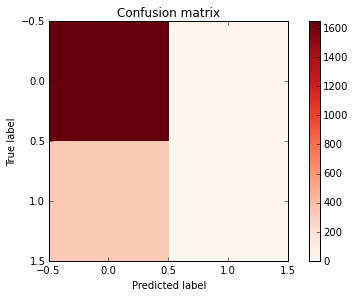

In [63]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm=confusion_matrix(y_test, lr_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

###Currently the model is exclusively predicting 'No' as seen in the confusion matrix. It is thus trivial that it is ~83% accurate; ~83% of flights are not cancelled.

In [45]:
#### Logistic Regression 
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print 1.0*sum(lr_pred == y_test)/len(y_test)
confusion_matrix(y_test, lr_pred)

0.593939393939


array([[965, 679],
       [125, 211]])

##Some other classifiers...

In [46]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

In [47]:
# Create classifiers
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)

0.830303030303


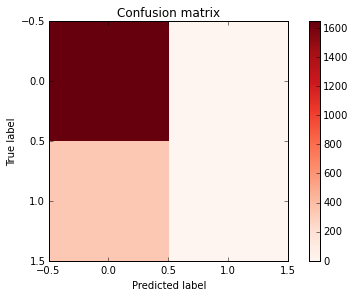

In [48]:
#### Gaussian Naive Bayes
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)

print 1.0*sum(gnb_pred == y_test)/len(y_test)
confusion_matrix(y_test, gnb_pred)

cm=confusion_matrix(y_test, gnb_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

0.184343434343


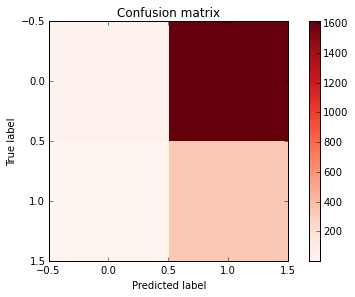

In [49]:
#### SVC
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print 1.0*sum(svc_pred == y_test)/len(y_test)
confusion_matrix(y_test, svc_pred)

cm=confusion_matrix(y_test, svc_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

In [50]:
y_train.value_counts()

0    3356
1     664
dtype: int64

In [51]:
y_test.value_counts()

0    1644
1     336
dtype: int64

In [52]:
np.unique(svc_pred, return_counts=True)

(array([0, 1]), array([  35, 1945]))

0.805555555556


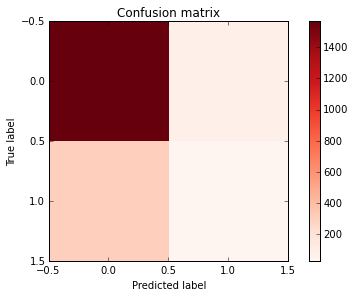

In [53]:
#### Random Forest
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print 1.0*sum(rfc_pred == y_test)/len(y_test)

cm=confusion_matrix(y_test, rfc_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

In [54]:
confusion_matrix(y_test, rfc_pred)

array([[1566,   78],
       [ 307,   29]])

###More Visualizations

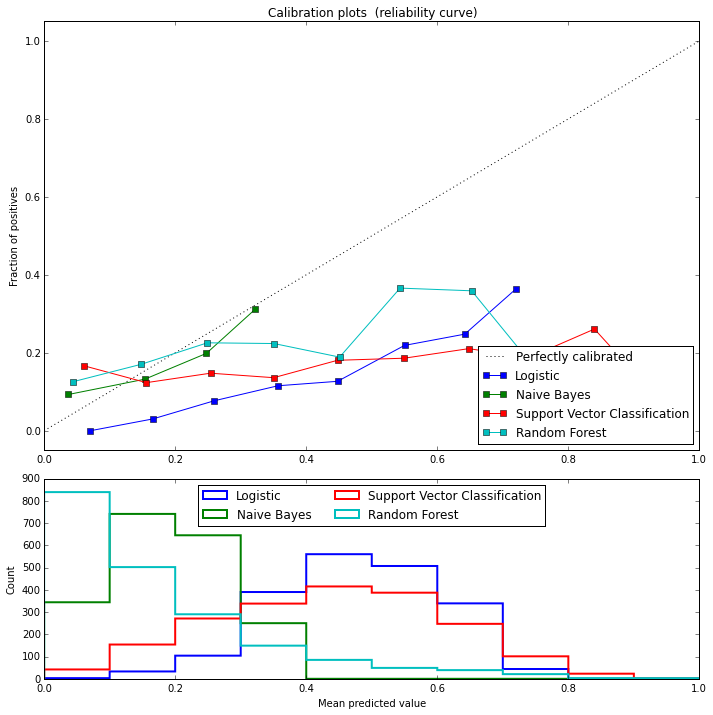

In [55]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, random_state=4444)

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cross_validation import cross_val_score
    
y_obs = Y_test

accuracy_dict = dict()
precision_dict = dict()
recall_dict = dict()
f1_dict = dict()
 
for algorithm in [KNeighborsClassifier(n_neighbors=10),
            LogisticRegression(C=0.001), 
            SVC(),  
            GaussianNB(), 
            DecisionTreeClassifier(), 
            RandomForestClassifier()]:
     
    algorithm.fit(X_train, Y_train)
    y_pred = algorithm.predict(X_test)
    alg_label = str(algorithm)
    alg_label = alg_label[:alg_label.index('(')]
    
    # create dictionary of stats
    accuracy_dict[alg_label] = accuracy_score(y_obs, y_pred)
    precision_dict[alg_label] = precision_score(y_obs, y_pred)
    recall_dict[alg_label] = recall_score(y_obs, y_pred)
    f1_dict[alg_label] = f1_score(y_obs, y_pred)

    print '\n'
    print alg_label
    print '-'*20
    print
    print "classification report"
    print classification_report(y_obs, y_pred)
    print
    print '   accuracy score             %.4f ' % (accuracy_score(y_obs, y_pred))
    print '   precision score            %.4f ' % precision_score(y_obs, y_pred)
    print '   recall score               %.4f ' % recall_score(y_obs, y_pred)
    print '   f1 score                   %.4f ' % f1_score(y_obs, y_pred)
    
    

    
def print_items(dictionary):
    for k,v in dictionary.iteritems():
        spaces = 30-len(k)
        newclf = k + ' '*spaces
        print '  %s %.4f' % (newclf, v)
        

print '\nPresent by Statistics to Compare Models'

print '\nAccuracy'
print_items(accuracy_dict)

print '\nPrecision'
print_items(precision_dict)

print '\nRecall'
print_items(recall_dict)

print '\nF1'
print_items(f1_dict)
    



KNeighborsClassifier
--------------------

classification report
             precision    recall  f1-score   support

          0       0.83      0.99      0.90      1242
          1       0.20      0.02      0.03       258

avg / total       0.72      0.82      0.75      1500


   accuracy score             0.8200 
   precision score            0.2000 
   recall score               0.0155 
   f1 score                   0.0288 


LogisticRegression
--------------------

classification report
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      1242
          1       0.00      0.00      0.00       258

avg / total       0.69      0.83      0.75      1500


   accuracy score             0.8280 
   precision score            0.0000 
   recall score               0.0000 
   f1 score                   0.0000 


SVC
--------------------

classification report
             precision    recall  f1-score   support

          0       0.83      

/Users/matthewmitchell/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matthewmitchell/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/matthewmitchell/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#Discussion/Commentary:
###As we can see, all of our models are being affected by a class imbalance problem here; most flights aren't cancelled. That said, the cost of false-positives vs false-negatives is drastically different in this scenario as well; we'd much prefer to not buy a flight that ends up running as scheduled then accidently buy a flight that is cancelled. What this translates to in terms of our model, is we need to be a bit cautious with boundary cases. We would rather prune a little too much and install confidence that if we say a flight will run it indeed does. 

###Mathematically, we are asking how to reweight our cost function. So rather than be the most accurate of correctly predicting each and every flight we simply want to be super-duper confident that some flights will not be cancelled. Thus if we can find a demographic that has some correlation or a higher rate of cancellations than the general population, we should stray away from these areas and advise caution to customers considering purchasing such flights.

In [64]:
#### Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print 1.0*sum(lr_pred == y_test)/len(y_test)
confusion_matrix(y_test, lr_pred)

0.831313131313


array([[1646,    0],
       [ 334,    0]])

In [65]:
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print 1.0*sum(lr_pred == y_test)/len(y_test)
confusion_matrix(y_test, lr_pred)

0.831313131313


array([[1646,    0],
       [ 334,    0]])

In [66]:
probabilities = lr.predict_proba(X_test)

In [69]:
print [np.percentile(probabilities, i*10) for i in range(1,10) ]

[0.10720763923238157, 0.13802459391307847, 0.18140025482850478, 0.22921338500858304, 0.5, 0.77078661499141699, 0.81859974517149514, 0.86197540608692158, 0.89279236076761836]


In [86]:
len(probabilities)

1980

In [91]:
probabilities[1]

array([ 0.91782192,  0.08217808])

In [103]:
canceled = [0 if i[0]>.75 else 1 for i in probabilities]

In [104]:
len(canceled)

1980

In [105]:
np.unique(canceled, return_counts=True)

(array([0, 1]), array([1709,  271]))

In [106]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([1646,  334]))

In [107]:
print 1.0*sum(canceled == y_test)/len(y_test)

0.765151515152


In [108]:
confusion_matrix(canceled, y_test)

array([[1445,  264],
       [ 201,   70]])

In [109]:
canceled = [0 if i[0]>.65 else 1 for i in probabilities]
print np.unique(canceled, return_counts=True)
confusion_matrix(canceled, y_test)

(array([0, 1]), array([1969,   11]))


array([[1638,  331],
       [   8,    3]])

In [111]:
canceled = [0 if i[0]>.5 else 1 for i in probabilities]
print np.unique(canceled, return_counts=True)
confusion_matrix(canceled, y_test)

(array([0]), array([1980]))


array([[1646,  334],
       [   0,    0]])

##SVM Revisited; lowering c to maximize decision boundary

0.826767676768


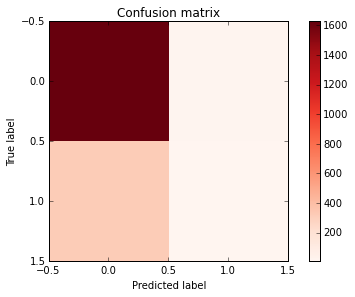

In [142]:
#### SVM
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=10, C=250)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print 1.0*sum(svc_pred == y_test)/len(y_test)
confusion_matrix(y_test, svc_pred)

cm=confusion_matrix(y_test, svc_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

In [143]:
cm

array([[1627,   19],
       [ 324,   10]])

In [146]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33)

0.722222222222


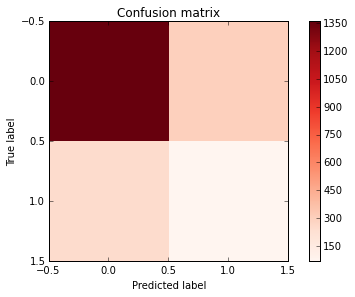

In [147]:
#### SVM
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=10, C=250)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print 1.0*sum(svc_pred == y_test)/len(y_test)
confusion_matrix(y_test, svc_pred)

cm=confusion_matrix(y_test, svc_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

In [151]:
cm

array([[1359,  298],
       [ 252,   71]])

In [150]:
#### Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print 1.0*sum(lr_pred == y_test)/len(y_test)
confusion_matrix(y_test, lr_pred)

0.836868686869


array([[1657,    0],
       [ 323,    0]])

##Decision Trees

In [153]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

confusion_matrix(y_test, tree_pred)

array([[1657,    0],
       [ 323,    0]])

##Resampling: Over/Undersamping to account for class imbalance...

In [163]:
from imblearn.over_sampling import RandomOverSampler

In [165]:
from sklearn.preprocessing import StandardScaler
#Norm Data
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

#Resample
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample(X_std, y)

#Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.33)

In [166]:
#### Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print 1.0*sum(lr_pred == y_test)/len(y_test)
confusion_matrix(y_test, lr_pred)

0.604545454545


array([[ 950,  687],
       [ 618, 1045]])

0.876363636364


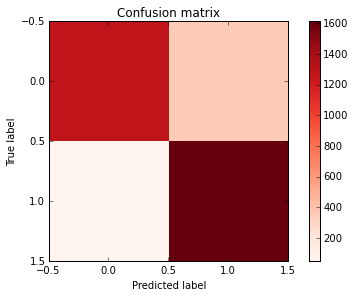

In [167]:
#### SVM
from sklearn.svm import SVC
svc = SVC(kernel='rbf', gamma=10, C=250)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

print 1.0*sum(svc_pred == y_test)/len(y_test)
confusion_matrix(y_test, svc_pred)

cm=confusion_matrix(y_test, svc_pred, labels=None)
plt.figure()
plot_confusion_matrix(cm)

In [168]:
cm

array([[1281,  356],
       [  52, 1611]])

#Very nice! This is the best classifier to date!; Very few false negatives!! (This is when you tell someone to buy a flight but it is then canceled)

In [169]:
len(y_resampled)

10000

In [170]:
len(X_resampled)

10000

##My custom resample

In [157]:
df.head()

,Canceled,Month,DepartureTime,UniqueCarrier,SchedElapsedTime,ArrDelay,DepDelay,Distance
0,1,12,814,UA,134,0,0,679
1,1,12,830,DL,90,0,0,214
2,1,1,1835,UA,213,0,0,1605
3,1,4,1730,AA,80,0,0,235
4,1,7,1442,UA,103,0,0,413


In [159]:
Canceled = df[df.Canceled==1]
Flew = df[df.Canceled==0]

In [162]:
Xpos = Canceled[['Month','DepartureTime','SchedElapsedTime','Distance']]
Xneg = Flew[['Month','DepartureTime','SchedElapsedTime','Distance']]
ypos = Canceled.Canceled
yneg = Flew.Canceled

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33)